# Imports

In [1]:
from itertools import product
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
import xgboost as xgb
import warnings

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
warnings.filterwarnings('ignore')

# Configs

In [3]:
INPUT_PATH = '/Users/maedeh/Desktop/demand_project/demand_project/shoofer-demand-prediction/data/features_df_phase2.parquet'
Ridge_PATH = '/Users/maedeh/Desktop/demand_project/demand_project/shoofer-demand-prediction/data/Ridge_feature_predictions_phase2.parquet'
XGB_ridge_PATH = '/Users/maedeh/Desktop/demand_project/demand_project/shoofer-demand-prediction/data/XGB_ridge_predictions_phase2.parquet'
XGB_PATH = '/Users/maedeh/Desktop/demand_project/demand_project/shoofer-demand-prediction/data/XGB_predictions_phase2.parquet'


FEATURE_LIST = ['day_of_week',
                'day_of_month',

                'max_previous_week_interval',
                'max_previous_7exact_interval',
    
                'previous_day_9interval',
                'previous_day_10interval',
                'previous_day_14interval',
                'previous_day_15interval',
                'previous_day_17interval',

                'avrg_previous_2day_8interval',
                
                'diff_previous_2day_interval',
                'diff_previous_2day_previous_interval',
    
                'previous_day_interval',
                'previous_2day_interval',
                'previous_3day_interval',
                'previous_4day_interval',
                'previous_5day_interval',
                'previous_6day_interval',
                'previous_week_interval',
                'previous_8day_interval',
                'previous_9day_interval',
                'previous_10day_interval',
                'previous_11day_interval',
                'previous_12day_interval',
                'previous_13day_interval',
                'previous_2week_interval'
               ]


TEST_START_DATE = '2023-04-1'
VALIDATION_START_DATE = '2023-03-18'

NUM_INTERVAL_PER_DAY = 8

AUTO_TUNE = False
add_ridge_feature = False

# Data preparation


## Load Data

In [4]:
features_df = pd.read_parquet(INPUT_PATH, engine='pyarrow')
print(f'features dataframe shape : {features_df.shape}')
features_df.head()

features dataframe shape : (251520, 7)


,Location,Date,Hour_interval,Demand,previous_day_interval,previous_week_interval,previous_2week_interval
0,1,2023-01-01,0,0.0,NaN,NaN,NaN
1,1,2023-01-01,3,1.0,NaN,NaN,NaN
2,1,2023-01-01,6,1.0,NaN,NaN,NaN
3,1,2023-01-01,9,1.0,NaN,NaN,NaN
4,1,2023-01-01,12,13.0,NaN,NaN,NaN


In [5]:
ridge_df = pd.read_parquet(Ridge_PATH, engine='pyarrow')
print(f'rides dataframe shape : {ridge_df.shape}')
ridge_df.head()

rides dataframe shape : (222176, 4)


,Location,Date,Hour_interval,Predicted_demand
0,1,2023-01-15,0,-0.046404
1,1,2023-01-15,3,0.610225
2,1,2023-01-15,6,2.055764
3,1,2023-01-15,9,1.146677
4,1,2023-01-15,12,5.979035


## Add feature

In [6]:
def add_feature(dataset, lag_num):
    
    for i in range(1,lag_num):
        if i not in(1,7):
            dataset[f'previous_{i}day_interval'] = dataset.groupby('Location')['Demand'].shift(i*NUM_INTERVAL_PER_DAY)

    
    dataset['day_of_week'] = dataset['Date'].dt.dayofweek
    dataset['day_of_month'] = dataset['Date'].dt.day
    dataset['time'] = dataset['Hour_interval']
    dataset['zone'] = dataset['Location']

    
    dataset['max_previous_week_interval'] = dataset.groupby('Location')['Demand'].rolling(window = 7*NUM_INTERVAL_PER_DAY).max().reset_index(drop=True)
    dataset['max_previous_2week_interval'] = dataset.groupby('Location')['Demand'].rolling(window = 14*NUM_INTERVAL_PER_DAY).max().reset_index(drop=True)

    
    df = dataset.sort_values(['Location','Hour_interval','Date'])[['Location','Hour_interval','Date','Demand']]
    df['max_previous_7exact_interval'] = dataset.groupby(['Location','Hour_interval'])['Demand'].rolling(window = 7).max().values
    dataset['max_previous_7exact_interval'] = df.sort_values(['Location', 'Date','Hour_interval'])['max_previous_7exact_interval']
    df['max_previous_14exact_interval'] = dataset.groupby(['Location','Hour_interval'])['Demand'].rolling(window = 14).max().values
    dataset['max_previous_14exact_interval'] = df.sort_values(['Location', 'Date','Hour_interval'])['max_previous_14exact_interval']

    
    dataset['previous_day_9interval'] = dataset.groupby('Location')['Demand'].shift(NUM_INTERVAL_PER_DAY+1)
    dataset['previous_day_10interval'] = dataset.groupby('Location')['Demand'].shift(NUM_INTERVAL_PER_DAY+2)
    dataset['previous_day_11interval'] = dataset.groupby('Location')['Demand'].shift(NUM_INTERVAL_PER_DAY+3)
    dataset['previous_day_12interval'] = dataset.groupby('Location')['Demand'].shift(NUM_INTERVAL_PER_DAY+4)
    dataset['previous_day_13interval'] = dataset.groupby('Location')['Demand'].shift(NUM_INTERVAL_PER_DAY+5)
    dataset['previous_day_14interval'] = dataset.groupby('Location')['Demand'].shift(NUM_INTERVAL_PER_DAY+6)
    dataset['previous_day_15interval'] = dataset.groupby('Location')['Demand'].shift(NUM_INTERVAL_PER_DAY+7)
    dataset['previous_day_17interval'] = dataset.groupby('Location')['Demand'].shift(NUM_INTERVAL_PER_DAY+9)

    
    dataset['avrg_previous_2day_8interval'] = (8*dataset['previous_day_9interval']+7*dataset['previous_day_10interval']+\
    6*dataset['previous_day_11interval']+5*dataset['previous_day_12interval']+4*dataset['previous_day_13interval']+\
    3*dataset['previous_day_14interval']+2*dataset['previous_day_15interval']+dataset['previous_2week_interval'])/NUM_INTERVAL_PER_DAY

    
    dataset['diff_previous_2day_previous_interval'] = dataset['previous_day_17interval']-dataset['previous_day_9interval']

    
    dataset['diff_previous_2day_interval'] = dataset['previous_day_interval']-dataset['previous_2day_interval']
    dataset['diff_previous_2week_interval'] = dataset['previous_week_interval']-dataset['previous_2week_interval']

    
    return dataset



In [7]:
new_features_df = add_feature(features_df, lag_num = 14)
print(f'new features dataframe shape : {new_features_df.shape}')
new_features_df.head()

new features dataframe shape : (251520, 38)


,Location,Date,Hour_interval,Demand,previous_day_interval,previous_week_interval,previous_2week_interval,previous_2day_interval,previous_3day_interval,previous_4day_interval,...,previous_day_11interval,previous_day_12interval,previous_day_13interval,previous_day_14interval,previous_day_15interval,previous_day_17interval,avrg_previous_2day_8interval,diff_previous_2day_previous_interval,diff_previous_2day_interval,diff_previous_2week_interval
0,1,2023-01-01,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2023-01-01,3,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2023-01-01,6,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2023-01-01,9,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,2023-01-01,12,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
def feature_selection(dataset, FEATURE_LIST):
    
    dataset = dataset[['Location','Date','Hour_interval','Demand']+FEATURE_LIST]
    dataset.dropna(inplace = True)
    
    return dataset

In [9]:
selected_features_df = feature_selection(new_features_df, FEATURE_LIST)
print(f'features dataframe shape : {selected_features_df.shape}')
selected_features_df.head()

features dataframe shape : (222176, 30)


,Location,Date,Hour_interval,Demand,day_of_week,day_of_month,max_previous_week_interval,max_previous_7exact_interval,previous_day_9interval,previous_day_10interval,...,previous_5day_interval,previous_6day_interval,previous_week_interval,previous_8day_interval,previous_9day_interval,previous_10day_interval,previous_11day_interval,previous_12day_interval,previous_13day_interval,previous_2week_interval
112,1,2023-01-15,0,0.0,6,15,14.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
113,1,2023-01-15,3,2.0,6,15,14.0,2.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,2.0,3.0,1.0
114,1,2023-01-15,6,1.0,6,15,14.0,2.0,0.0,0.0,...,0.0,2.0,3.0,1.0,0.0,2.0,2.0,2.0,4.0,1.0
115,1,2023-01-15,9,0.0,6,15,14.0,1.0,1.0,0.0,...,1.0,1.0,1.0,1.0,0.0,2.0,0.0,2.0,4.0,1.0
116,1,2023-01-15,12,8.0,6,15,14.0,8.0,1.0,1.0,...,1.0,1.0,2.0,1.0,3.0,4.0,3.0,7.0,11.0,13.0


In [10]:
def join_ridge_feature(dataset, ridge_df, FEATURE_LIST):

    dataset = dataset.merge(ridge_df, how='outer', on = ['Location','Date','Hour_interval'])
    FEATURE_LIST.append('Predicted_demand')
    
    return dataset, FEATURE_LIST

In [11]:
if add_ridge_feature:
    selected_features_df, FEATURE_LIST = join_ridge_feature(selected_features_df, ridge_df, FEATURE_LIST)
    print(f'final features dataframe shape : {selected_features_df.shape}')
selected_features_df.head()

,Location,Date,Hour_interval,Demand,day_of_week,day_of_month,max_previous_week_interval,max_previous_7exact_interval,previous_day_9interval,previous_day_10interval,...,previous_5day_interval,previous_6day_interval,previous_week_interval,previous_8day_interval,previous_9day_interval,previous_10day_interval,previous_11day_interval,previous_12day_interval,previous_13day_interval,previous_2week_interval
112,1,2023-01-15,0,0.0,6,15,14.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
113,1,2023-01-15,3,2.0,6,15,14.0,2.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,2.0,3.0,1.0
114,1,2023-01-15,6,1.0,6,15,14.0,2.0,0.0,0.0,...,0.0,2.0,3.0,1.0,0.0,2.0,2.0,2.0,4.0,1.0
115,1,2023-01-15,9,0.0,6,15,14.0,1.0,1.0,0.0,...,1.0,1.0,1.0,1.0,0.0,2.0,0.0,2.0,4.0,1.0
116,1,2023-01-15,12,8.0,6,15,14.0,8.0,1.0,1.0,...,1.0,1.0,2.0,1.0,3.0,4.0,3.0,7.0,11.0,13.0


## Split Train, Validation and Test Data

In [12]:
def train_test_splitting(dataset, START_DATE):

    train_df = dataset[dataset['Date'] < START_DATE]
    test_df = dataset[dataset['Date'] >= START_DATE]

    return train_df, test_df

In [13]:
train_df, test_df = train_test_splitting(selected_features_df, TEST_START_DATE)

In [14]:
print(f'train dataframe shape : {train_df.shape}')
train_df.head()

train dataframe shape : (159296, 30)


,Location,Date,Hour_interval,Demand,day_of_week,day_of_month,max_previous_week_interval,max_previous_7exact_interval,previous_day_9interval,previous_day_10interval,...,previous_5day_interval,previous_6day_interval,previous_week_interval,previous_8day_interval,previous_9day_interval,previous_10day_interval,previous_11day_interval,previous_12day_interval,previous_13day_interval,previous_2week_interval
112,1,2023-01-15,0,0.0,6,15,14.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
113,1,2023-01-15,3,2.0,6,15,14.0,2.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,2.0,3.0,1.0
114,1,2023-01-15,6,1.0,6,15,14.0,2.0,0.0,0.0,...,0.0,2.0,3.0,1.0,0.0,2.0,2.0,2.0,4.0,1.0
115,1,2023-01-15,9,0.0,6,15,14.0,1.0,1.0,0.0,...,1.0,1.0,1.0,1.0,0.0,2.0,0.0,2.0,4.0,1.0
116,1,2023-01-15,12,8.0,6,15,14.0,8.0,1.0,1.0,...,1.0,1.0,2.0,1.0,3.0,4.0,3.0,7.0,11.0,13.0


In [15]:
print(f'test dataframe shape : {test_df.shape}')
test_df.head()

test dataframe shape : (62880, 30)


,Location,Date,Hour_interval,Demand,day_of_week,day_of_month,max_previous_week_interval,max_previous_7exact_interval,previous_day_9interval,previous_day_10interval,...,previous_5day_interval,previous_6day_interval,previous_week_interval,previous_8day_interval,previous_9day_interval,previous_10day_interval,previous_11day_interval,previous_12day_interval,previous_13day_interval,previous_2week_interval
720,1,2023-04-01,0,0.0,5,1,6.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
721,1,2023-04-01,3,1.0,5,1,6.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,2.0
722,1,2023-04-01,6,1.0,5,1,6.0,3.0,0.0,0.0,...,0.0,0.0,3.0,0.0,5.0,2.0,0.0,1.0,1.0,7.0
723,1,2023-04-01,9,0.0,5,1,6.0,3.0,0.0,0.0,...,0.0,0.0,2.0,1.0,1.0,3.0,1.0,1.0,2.0,2.0
724,1,2023-04-01,12,1.0,5,1,6.0,5.0,2.0,0.0,...,2.0,5.0,3.0,2.0,4.0,0.0,0.0,3.0,9.0,2.0


In [16]:
gridsearch_train_df, validation_df = train_test_splitting(train_df, VALIDATION_START_DATE)

In [17]:
print(f'gridsearch_train dataframe shape : {gridsearch_train_df.shape}')
gridsearch_train_df.head()

gridsearch_train dataframe shape : (129952, 30)


,Location,Date,Hour_interval,Demand,day_of_week,day_of_month,max_previous_week_interval,max_previous_7exact_interval,previous_day_9interval,previous_day_10interval,...,previous_5day_interval,previous_6day_interval,previous_week_interval,previous_8day_interval,previous_9day_interval,previous_10day_interval,previous_11day_interval,previous_12day_interval,previous_13day_interval,previous_2week_interval
112,1,2023-01-15,0,0.0,6,15,14.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
113,1,2023-01-15,3,2.0,6,15,14.0,2.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,2.0,3.0,1.0
114,1,2023-01-15,6,1.0,6,15,14.0,2.0,0.0,0.0,...,0.0,2.0,3.0,1.0,0.0,2.0,2.0,2.0,4.0,1.0
115,1,2023-01-15,9,0.0,6,15,14.0,1.0,1.0,0.0,...,1.0,1.0,1.0,1.0,0.0,2.0,0.0,2.0,4.0,1.0
116,1,2023-01-15,12,8.0,6,15,14.0,8.0,1.0,1.0,...,1.0,1.0,2.0,1.0,3.0,4.0,3.0,7.0,11.0,13.0


In [18]:
print(f'validation dataframe shape : {validation_df.shape}')
validation_df.head()

validation dataframe shape : (29344, 30)


,Location,Date,Hour_interval,Demand,day_of_week,day_of_month,max_previous_week_interval,max_previous_7exact_interval,previous_day_9interval,previous_day_10interval,...,previous_5day_interval,previous_6day_interval,previous_week_interval,previous_8day_interval,previous_9day_interval,previous_10day_interval,previous_11day_interval,previous_12day_interval,previous_13day_interval,previous_2week_interval
608,1,2023-03-18,0,1.0,5,18,9.0,1.0,0.0,2.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
609,1,2023-03-18,3,2.0,5,18,9.0,4.0,0.0,0.0,...,1.0,4.0,0.0,0.0,1.0,0.0,1.0,2.0,0.0,2.0
610,1,2023-03-18,6,7.0,5,18,9.0,7.0,1.0,0.0,...,4.0,1.0,0.0,2.0,3.0,1.0,1.0,1.0,4.0,1.0
611,1,2023-03-18,9,2.0,5,18,9.0,5.0,1.0,1.0,...,4.0,5.0,0.0,2.0,2.0,1.0,2.0,0.0,1.0,2.0
612,1,2023-03-18,12,2.0,5,18,9.0,9.0,2.0,1.0,...,0.0,5.0,5.0,1.0,1.0,8.0,2.0,2.0,3.0,0.0


# Model Training

## **Gradient Boosting Regressor**

### Model Tuning

In [19]:
def grid_search(test_parameters, train_data, validation_data, feature_list):
    best_score = float('inf')
    best_params = None
    param_combination = product(*test_parameters.values())
    
    for param in param_combination:

        param_dict = dict(zip(test_parameters.keys(), param))
        model = xgb.XGBRegressor(**param_dict)
        model.fit(train_data[feature_list], train_data['Demand'])
        
        validation_predict_df = model.predict(validation_data[feature_list])
        score = mean_squared_error(validation_data['Demand'], validation_predict_df)
        
        if score<best_score:
            best_score = score
            best_params = param_dict
            
    return best_params, best_score

In [20]:
if AUTO_TUNE:
    params_test = { 'learning_rate':[0.05, 0.1, 0.15], 
                    'subsample':[0.7, 0.8, 0.9], 
                    'colsample_bytree':[0.6, 0.8, 0.9], 
                    'max_depth':[7, 8, 9, 10, 12], 
                    'min_child_weight':[10, 20, 5],
                    'n_estimators':[100]
                    }

    best_params, best_score = grid_search(
        test_parameters = params_test,
        train_data = gridsearch_train_df, 
        validation_data = validation_df, 
        feature_list = FEATURE_LIST
        )
    
    print(best_params, best_score)
else:
    best_params = {'colsample_bytree': 0.9, 
                   'min_child_weight': 20, 
                   'learning_rate': 0.01, 
                   'max_depth': 10, 
                   'subsample': 0.8, 
                   'n_estimators': 500
                   }

### Prediction

In [21]:
def model_predict(model, train_data, test_data, feature_list):

    model.fit(train_data[feature_list], train_data['Demand'])
    
    train_predict_df  = model.predict(train_data[feature_list])
    test_predict_df  = model.predict(test_data[feature_list])

    return train_predict_df, test_predict_df

In [22]:
model = xgb.XGBRegressor(**best_params)
train_prediction_df, test_prediction_df = model_predict(model, train_df, test_df, FEATURE_LIST)

### Visualization

In [23]:
def prediction_visualization(train_data, test_data, train_prediction_df, test_prediction_df):

    predicted_train_df = train_data
    predicted_test_df = test_data
    predicted_train_df['Predicted'] = train_prediction_df
    predicted_test_df['Predicted'] = test_prediction_df
    
    train_data = train_data.groupby(['Date','Hour_interval'])['Demand'].sum()
    test_data = test_data.groupby(['Date','Hour_interval'])['Demand'].sum()
    predicted_train_df = predicted_train_df.groupby(['Date','Hour_interval'])['Predicted'].sum()
    predicted_test_df = predicted_test_df.groupby(['Date','Hour_interval'])['Predicted'].sum()

    plt.figure(figsize=(30,10))
    plt.title('Train', fontsize = 30)
    plt.plot(range(1,len(train_data)+1), train_data)
    plt.plot(range(1,len(train_data)+1), predicted_train_df)
    plt.xlabel('time interval', fontsize = 15)
    plt.legend(["Real Value", "Predicted"], loc ="lower right", fontsize = 15)
    plt.show()

    plt.figure(figsize=(30,10))
    plt.title('Test', fontsize = 30)
    plt.plot(range(1,len(test_data)+1), test_data)
    plt.plot(range(1,len(test_data)+1), predicted_test_df)
    plt.xlabel('time interval', fontsize = 15)
    plt.legend(["Real Value", "Predicted"], loc ="lower right", fontsize = 15)
    plt.show()

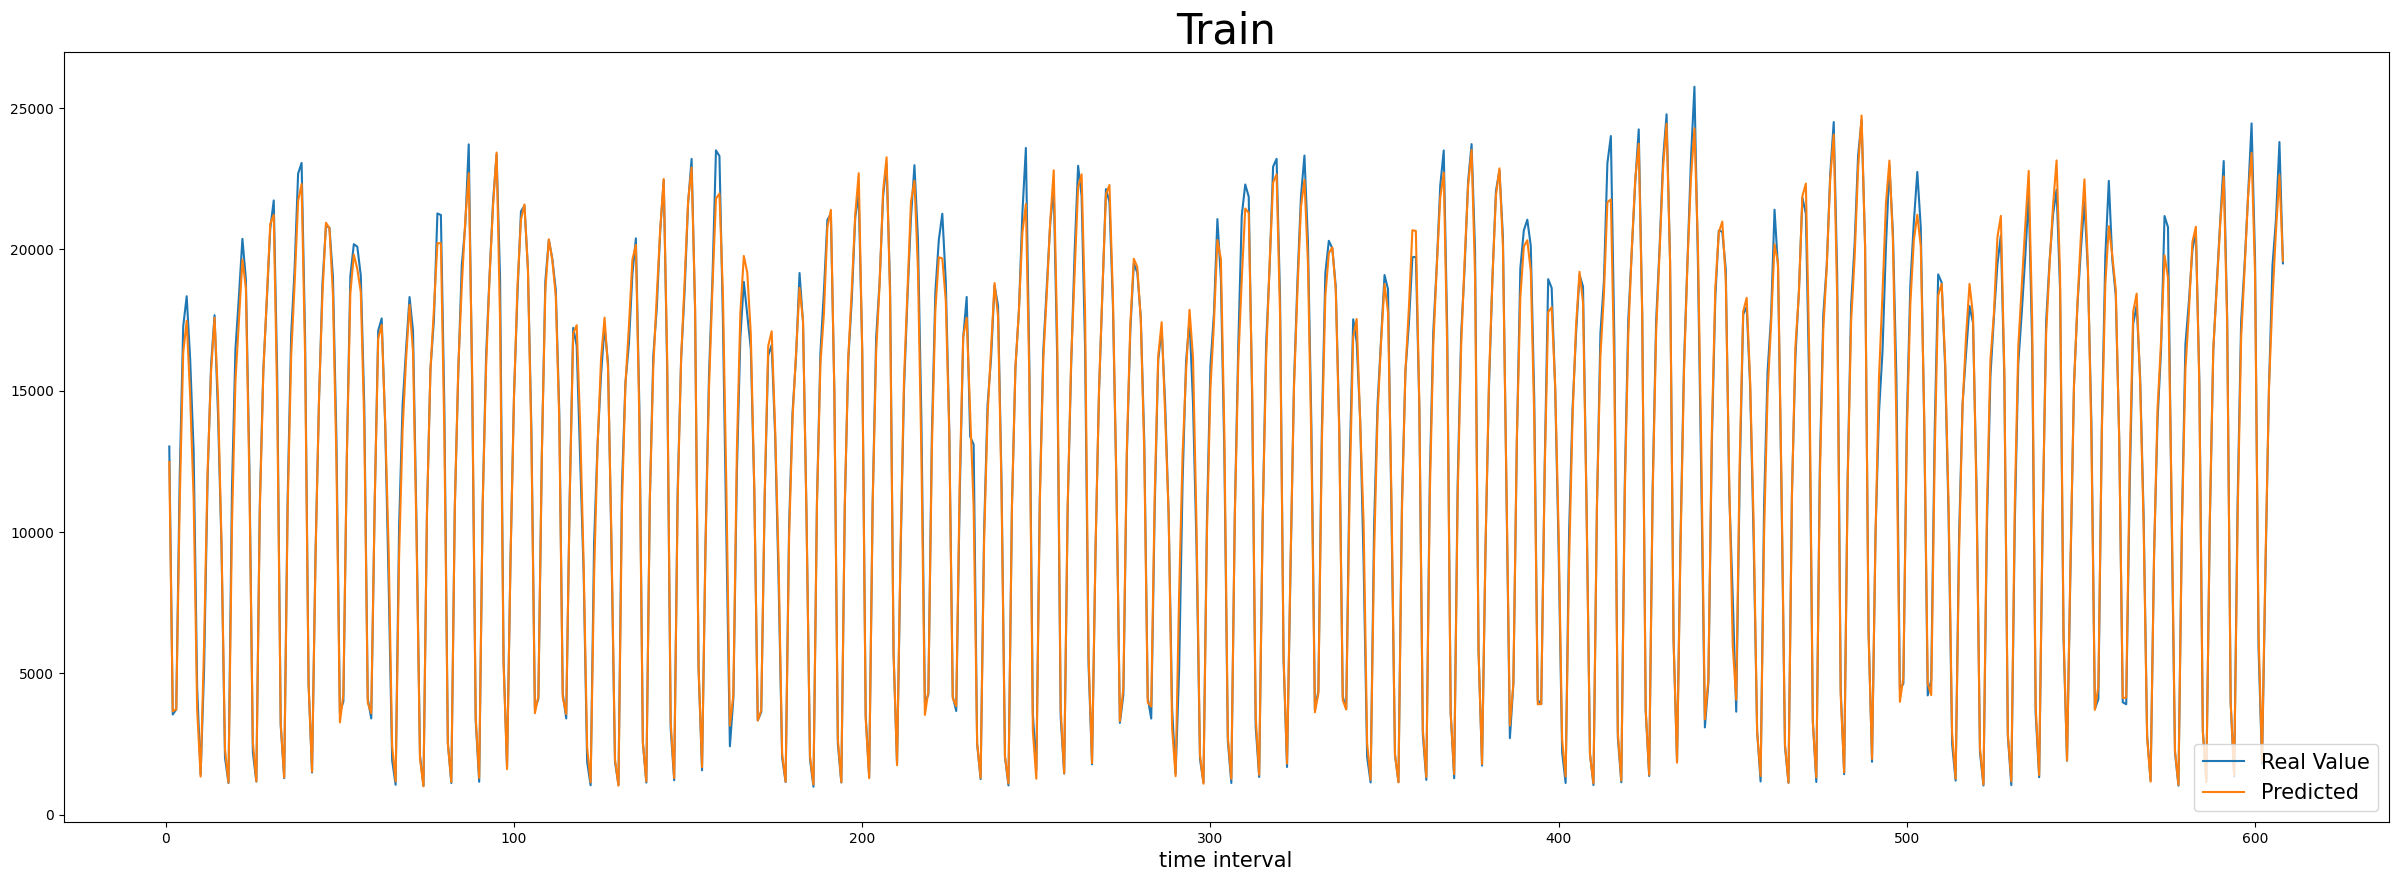

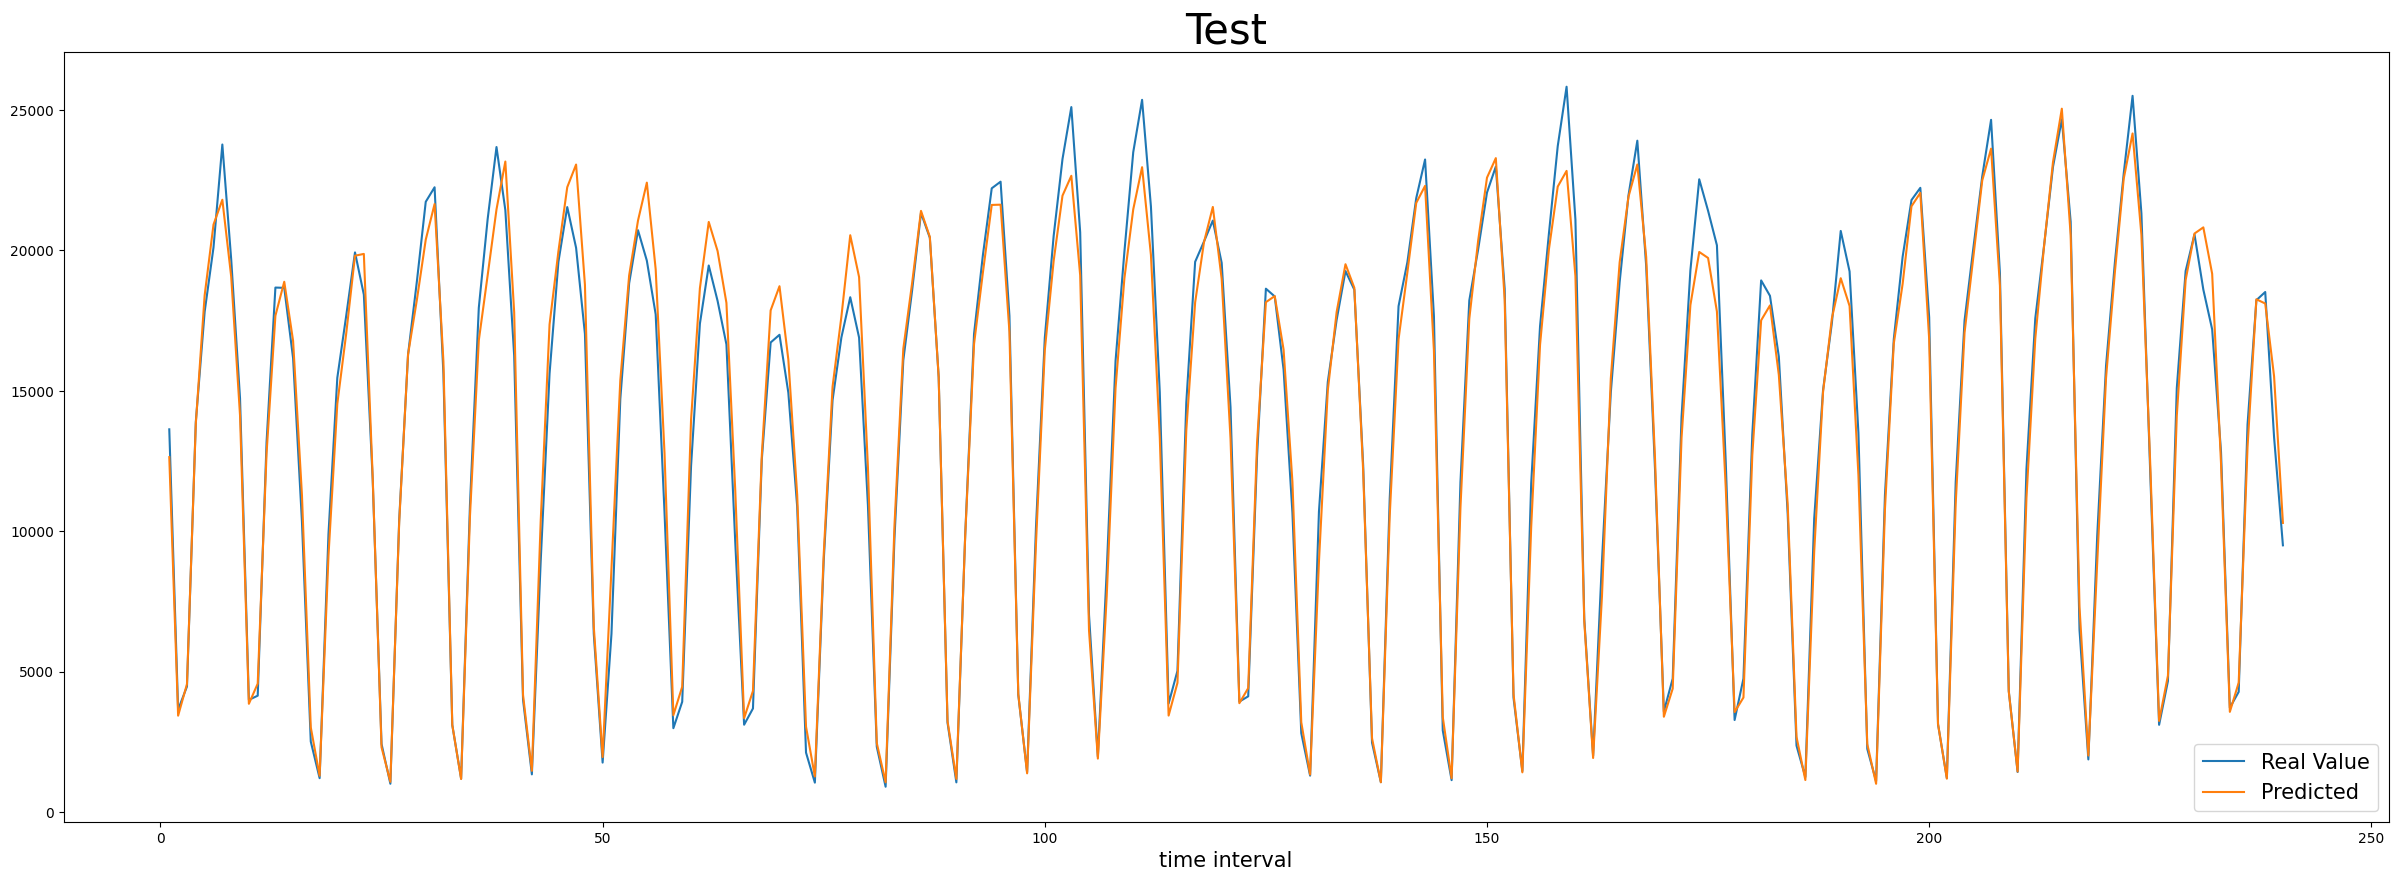

In [24]:
prediction_visualization(train_df, test_df, train_prediction_df, test_prediction_df)

### Evaluation

In [25]:
def evaluate(metric, metric_name, true_values, predicted_values):
    print(f'{metric_name} : {metric(true_values, predicted_values)}')

In [26]:
def evaluation(model_name, train_df, test_df, train_prediction_df, test_prediction_df):
    print(f'{model_name} train scores:')


    evaluate(mean_absolute_error, 'MAE', train_df['Demand'], train_prediction_df)
    evaluate(mean_squared_error, 'MSE', train_df['Demand'], train_prediction_df)
    evaluate(mean_absolute_percentage_error, 'MAPE', train_df['Demand'], train_prediction_df)


    print(f'{model_name} test scores:')

    evaluate(mean_absolute_error, 'MAE', test_df['Demand'], test_prediction_df)
    evaluate(mean_squared_error, 'MSE', test_df['Demand'], test_prediction_df)
    evaluate(mean_absolute_percentage_error, 'MAPE', test_df['Demand'], test_prediction_df)



In [27]:
evaluation('XGB', train_df, test_df, train_prediction_df, test_prediction_df)

XGB train scores:
MAE : 4.123671175232053
MSE : 168.30136380666366
MAPE : 705728944985109.0
XGB test scores:
MAE : 5.882992524682466
MSE : 371.61299711913676
MAPE : 725858057997466.8


### Feature Importance and SHAPE

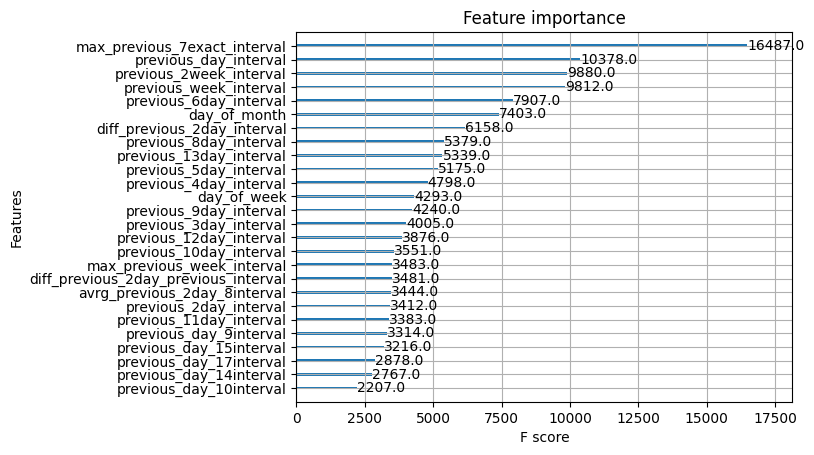

In [28]:
xgb.plot_importance(model)
plt.show()

In [29]:
# dtrain_reg = xgb.DMatrix(train_df[FEATURE_LIST].values, train_df['Demand'].values, enable_categorical=True)

# explainer = shap.TreeExplainer(model)
# shap_values = explainer.shap_values(dtrain_reg)
# shap.summary_plot(shap_values, train_df[FEATURE_LIST])

# File Saving

In [30]:
def save_predictions(dataset, path):
    dataset.to_parquet(path, index=False)

In [31]:
def prediction_labeling(pred_df, labeled_df):
    labeled_df.reset_index(inplace = True)
    labeled_prediction_df = labeled_df[['Location', 'Date', 'Hour_interval']]
    labeled_prediction_df['Predicted_demand'] = pred_df
    return labeled_prediction_df

In [32]:
labeled_prediction_df = prediction_labeling(test_prediction_df, test_df)

In [33]:
print(f'labeled prediction dataframe shape : {labeled_prediction_df.shape}')
labeled_prediction_df.head()

labeled prediction dataframe shape : (62880, 4)


,Location,Date,Hour_interval,Predicted_demand
0,1,2023-04-01,0,0.059216
1,1,2023-04-01,3,0.400379
2,1,2023-04-01,6,1.639149
3,1,2023-04-01,9,1.369392
4,1,2023-04-01,12,2.594998


In [34]:
if add_ridge_feature:
    OUTPUT_PATH = XGB_ridge_PATH
else:
    OUTPUT_PATH = XGB_PATH


save_predictions(labeled_prediction_df, OUTPUT_PATH)